In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 10.5 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.25
batch_size_value = 64
n_repeats = 3
n_epochs = 50
lr = 1e-3
# noise = 'topological'
# noise = 'salt&pepper'
noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 1s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'gaussian':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:00<00:00, 21960.36it/s]



salt&pepper noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 21930.31it/s]


salt&pepper noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

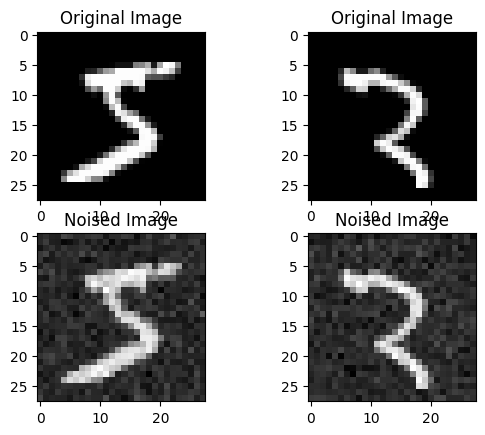

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

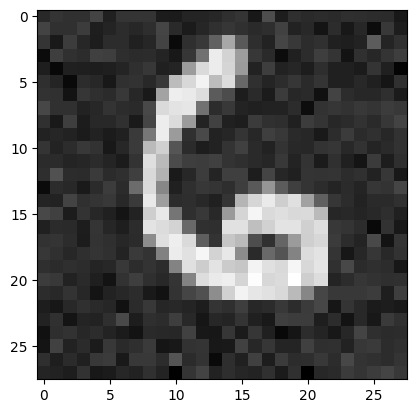

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

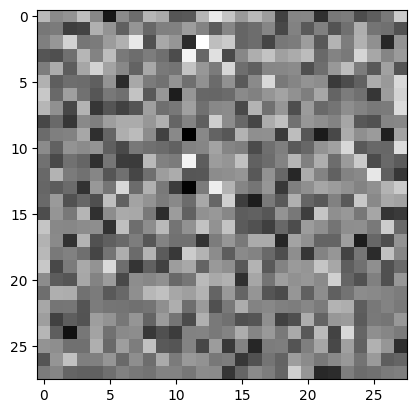

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(957.4922, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

2291.239501953125

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000, -0.0156, -0.0156,  ...,  0.0156,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0156,  0.0000, -0.0156],
        [-0.0156,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, -0.0156,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0156,  ...,  0.0000,  0.0156,  0.0000],
        [ 0.0000,  0.0000, -0.0156,  ...,  0.0000,  0.0000,  0.0000]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


  0 3649.2405 1505.7156


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


  1 2166.7322 1236.0763


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


  2 1856.5487 1180.1681


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


  3 1720.8615 1153.3595


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


  4 1653.3704 1134.4351


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


  5 1614.0150 1124.8513


100%|██████████| 157/157 [03:12<00:00,  1.23s/it]


  6 1589.9167 1118.6019


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


  7 1573.8424 1113.0581


100%|██████████| 157/157 [03:15<00:00,  1.24s/it]


  8 1562.5245 1107.9713


100%|██████████| 157/157 [03:14<00:00,  1.24s/it]


  9 1550.7008 1100.4944


100%|██████████| 157/157 [03:12<00:00,  1.23s/it]


 10 1540.9854 1098.5834


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 11 1533.3483 1096.5400


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 12 1525.7345 1092.1371


100%|██████████| 157/157 [03:12<00:00,  1.22s/it]


 13 1518.6469 1091.4158


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 14 1511.8850 1088.1512


100%|██████████| 157/157 [03:12<00:00,  1.22s/it]


 15 1504.5409 1085.3958


100%|██████████| 157/157 [03:15<00:00,  1.24s/it]


 16 1501.2115 1083.5477


100%|██████████| 157/157 [03:15<00:00,  1.25s/it]


 17 1495.7126 1080.7179


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 18 1489.1447 1078.4059


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 19 1483.8936 1074.8802


100%|██████████| 157/157 [03:12<00:00,  1.23s/it]


 20 1478.3916 1072.7799


100%|██████████| 157/157 [03:12<00:00,  1.23s/it]


 21 1472.3348 1072.5842


100%|██████████| 157/157 [03:10<00:00,  1.22s/it]


 22 1463.8046 1067.2291


100%|██████████| 157/157 [03:12<00:00,  1.23s/it]


 23 1461.9592 1069.6945


100%|██████████| 157/157 [03:12<00:00,  1.23s/it]


 24 1452.8495 1066.6808


100%|██████████| 157/157 [03:14<00:00,  1.24s/it]


 25 1446.6586 1063.4829


100%|██████████| 157/157 [03:12<00:00,  1.23s/it]


 26 1441.1487 1062.3873


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 27 1434.9352 1061.5577


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 28 1428.0764 1060.8945


100%|██████████| 157/157 [03:14<00:00,  1.24s/it]


 29 1421.7664 1057.6053


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 30 1414.6407 1057.8320


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 31 1406.7174 1055.3854


100%|██████████| 157/157 [03:12<00:00,  1.23s/it]


 32 1400.9857 1052.0852


100%|██████████| 157/157 [03:14<00:00,  1.24s/it]


 33 1396.9070 1052.4369


100%|██████████| 157/157 [03:14<00:00,  1.24s/it]


 34 1389.8621 1050.7854


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 35 1385.5034 1050.8643


100%|██████████| 157/157 [03:14<00:00,  1.24s/it]


 36 1380.0186 1050.2090


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 37 1374.2166 1048.5253


100%|██████████| 157/157 [03:14<00:00,  1.24s/it]


 38 1370.0072 1047.0139


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 39 1364.5116 1045.4403


100%|██████████| 157/157 [03:14<00:00,  1.24s/it]


 40 1359.3702 1042.1113


100%|██████████| 157/157 [03:15<00:00,  1.25s/it]


 41 1355.0587 1043.2734


100%|██████████| 157/157 [03:15<00:00,  1.24s/it]


 42 1349.8036 1042.5482


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 43 1347.9729 1042.3263


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 44 1342.8240 1039.2303


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 45 1340.9485 1039.4628


100%|██████████| 157/157 [03:15<00:00,  1.24s/it]


 46 1337.7239 1039.5802


100%|██████████| 157/157 [03:15<00:00,  1.24s/it]


 47 1333.4076 1038.3356


100%|██████████| 157/157 [03:16<00:00,  1.25s/it]


 48 1330.5101 1036.9723


100%|██████████| 157/157 [03:15<00:00,  1.24s/it]


 49 1326.2184 1037.1667

  2 MSE    Topo  


100%|██████████| 157/157 [03:20<00:00,  1.28s/it]


  0 3668.3586 1527.0316


100%|██████████| 157/157 [03:15<00:00,  1.24s/it]


  1 2176.2271 1232.8112


100%|██████████| 157/157 [03:16<00:00,  1.25s/it]


  2 1860.5116 1178.9031


100%|██████████| 157/157 [03:17<00:00,  1.26s/it]


  3 1725.5051 1152.3337


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


  4 1654.7509 1135.2902


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


  5 1620.4987 1124.2334


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


  6 1599.4982 1115.6857


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


  7 1583.4429 1106.6344


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


  8 1569.2433 1103.0693


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


  9 1557.8036 1100.7015


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 10 1547.0227 1097.2330


100%|██████████| 157/157 [03:07<00:00,  1.19s/it]


 11 1536.9163 1092.0591


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 12 1527.4659 1087.0823


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 13 1518.7399 1086.9890


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 14 1510.6639 1085.0975


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 15 1502.5353 1083.1489


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 16 1495.7777 1078.0271


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 17 1488.6057 1078.5887


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 18 1482.5660 1073.7239


100%|██████████| 157/157 [03:07<00:00,  1.19s/it]


 19 1475.5208 1071.6270


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 20 1470.2990 1069.6985


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 21 1466.4021 1067.3457


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 22 1457.8674 1065.9038


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 23 1454.1149 1061.7313


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 24 1448.8462 1063.2983


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 25 1440.6404 1061.3141


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 26 1435.4574 1058.9769


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 27 1429.7079 1057.1248


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 28 1423.2241 1053.5850


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 29 1418.2064 1052.8352


100%|██████████| 157/157 [03:14<00:00,  1.24s/it]


 30 1412.9912 1051.2494


100%|██████████| 157/157 [03:17<00:00,  1.26s/it]


 31 1405.3569 1049.9075


100%|██████████| 157/157 [03:16<00:00,  1.25s/it]


 32 1400.3762 1048.4136


100%|██████████| 157/157 [03:17<00:00,  1.26s/it]


 33 1396.6917 1045.4075


100%|██████████| 157/157 [03:17<00:00,  1.26s/it]


 34 1391.0201 1045.9987


100%|██████████| 157/157 [03:17<00:00,  1.26s/it]


 35 1386.2000 1042.2655


100%|██████████| 157/157 [03:16<00:00,  1.25s/it]


 36 1381.2317 1039.9738


100%|██████████| 157/157 [03:15<00:00,  1.24s/it]


 37 1377.0603 1039.5577


100%|██████████| 157/157 [03:16<00:00,  1.25s/it]


 38 1373.9371 1037.6792


100%|██████████| 157/157 [03:15<00:00,  1.25s/it]


 39 1369.4017 1038.9958


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 40 1365.0757 1038.0547


100%|██████████| 157/157 [03:13<00:00,  1.23s/it]


 41 1361.8807 1036.2018


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 42 1358.9188 1034.6069


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 43 1352.9512 1033.0675


100%|██████████| 157/157 [03:09<00:00,  1.20s/it]


 44 1350.8478 1032.1733


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 45 1347.4900 1032.1490


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 46 1343.6541 1030.8334


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 47 1341.7367 1029.9510


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 48 1337.9775 1028.9413


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 49 1333.8904 1026.2947

  3 MSE    Topo  


100%|██████████| 157/157 [03:15<00:00,  1.24s/it]


  0 3662.8958 1532.2528


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


  1 2141.1599 1227.5822


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


  2 1852.7480 1176.3735


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


  3 1716.1938 1148.2194


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


  4 1647.4801 1133.9534


100%|██████████| 157/157 [03:09<00:00,  1.20s/it]


  5 1609.3533 1120.6266


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


  6 1584.4407 1113.8766


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


  7 1565.6838 1107.8927


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


  8 1550.4762 1101.8101


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


  9 1537.5944 1097.9753


100%|██████████| 157/157 [03:07<00:00,  1.20s/it]


 10 1529.0100 1095.0070


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 11 1517.8855 1090.4113


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 12 1508.3203 1086.3995


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 13 1501.4246 1081.4022


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 14 1493.6272 1081.1202


100%|██████████| 157/157 [03:09<00:00,  1.20s/it]


 15 1483.7290 1077.6121


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 16 1478.2374 1077.8882


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 17 1472.4464 1071.3899


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 18 1466.1830 1069.7025


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 19 1459.3879 1068.1458


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 20 1451.5833 1067.0800


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 21 1446.6553 1063.1245


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 22 1440.3853 1062.3809


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 23 1435.8619 1058.9761


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 24 1431.2251 1056.8312


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 25 1424.6462 1057.3885


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 26 1419.0101 1055.6857


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 27 1412.2850 1053.2826


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 28 1409.5980 1053.8219


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 29 1404.2657 1050.4568


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 30 1399.4681 1049.0471


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 31 1394.3358 1048.7368


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 32 1390.3101 1046.4729


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 33 1385.0880 1044.6926


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 34 1380.4303 1044.4807


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 35 1377.9875 1042.7480


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 36 1371.9905 1042.1376


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 37 1369.8015 1040.2374


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 38 1366.2064 1039.4275


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 39 1361.1886 1037.2329


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 40 1358.4609 1037.8726


100%|██████████| 157/157 [03:08<00:00,  1.20s/it]


 41 1354.8784 1035.2046


100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


 42 1351.2002 1034.5774


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 43 1348.0612 1031.6658


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 44 1344.5067 1031.0835


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 45 1342.0187 1029.9897


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]


 46 1338.2010 1028.3792


100%|██████████| 157/157 [03:09<00:00,  1.21s/it]


 47 1335.7446 1028.5773


100%|██████████| 157/157 [03:09<00:00,  1.20s/it]


 48 1333.4357 1027.7572


100%|██████████| 157/157 [03:10<00:00,  1.21s/it]

 49 1329.8683 1024.5376

CPU times: user 15h 48min 18s, sys: 48.5 s, total: 15h 49min 7s
Wall time: 7h 59min


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

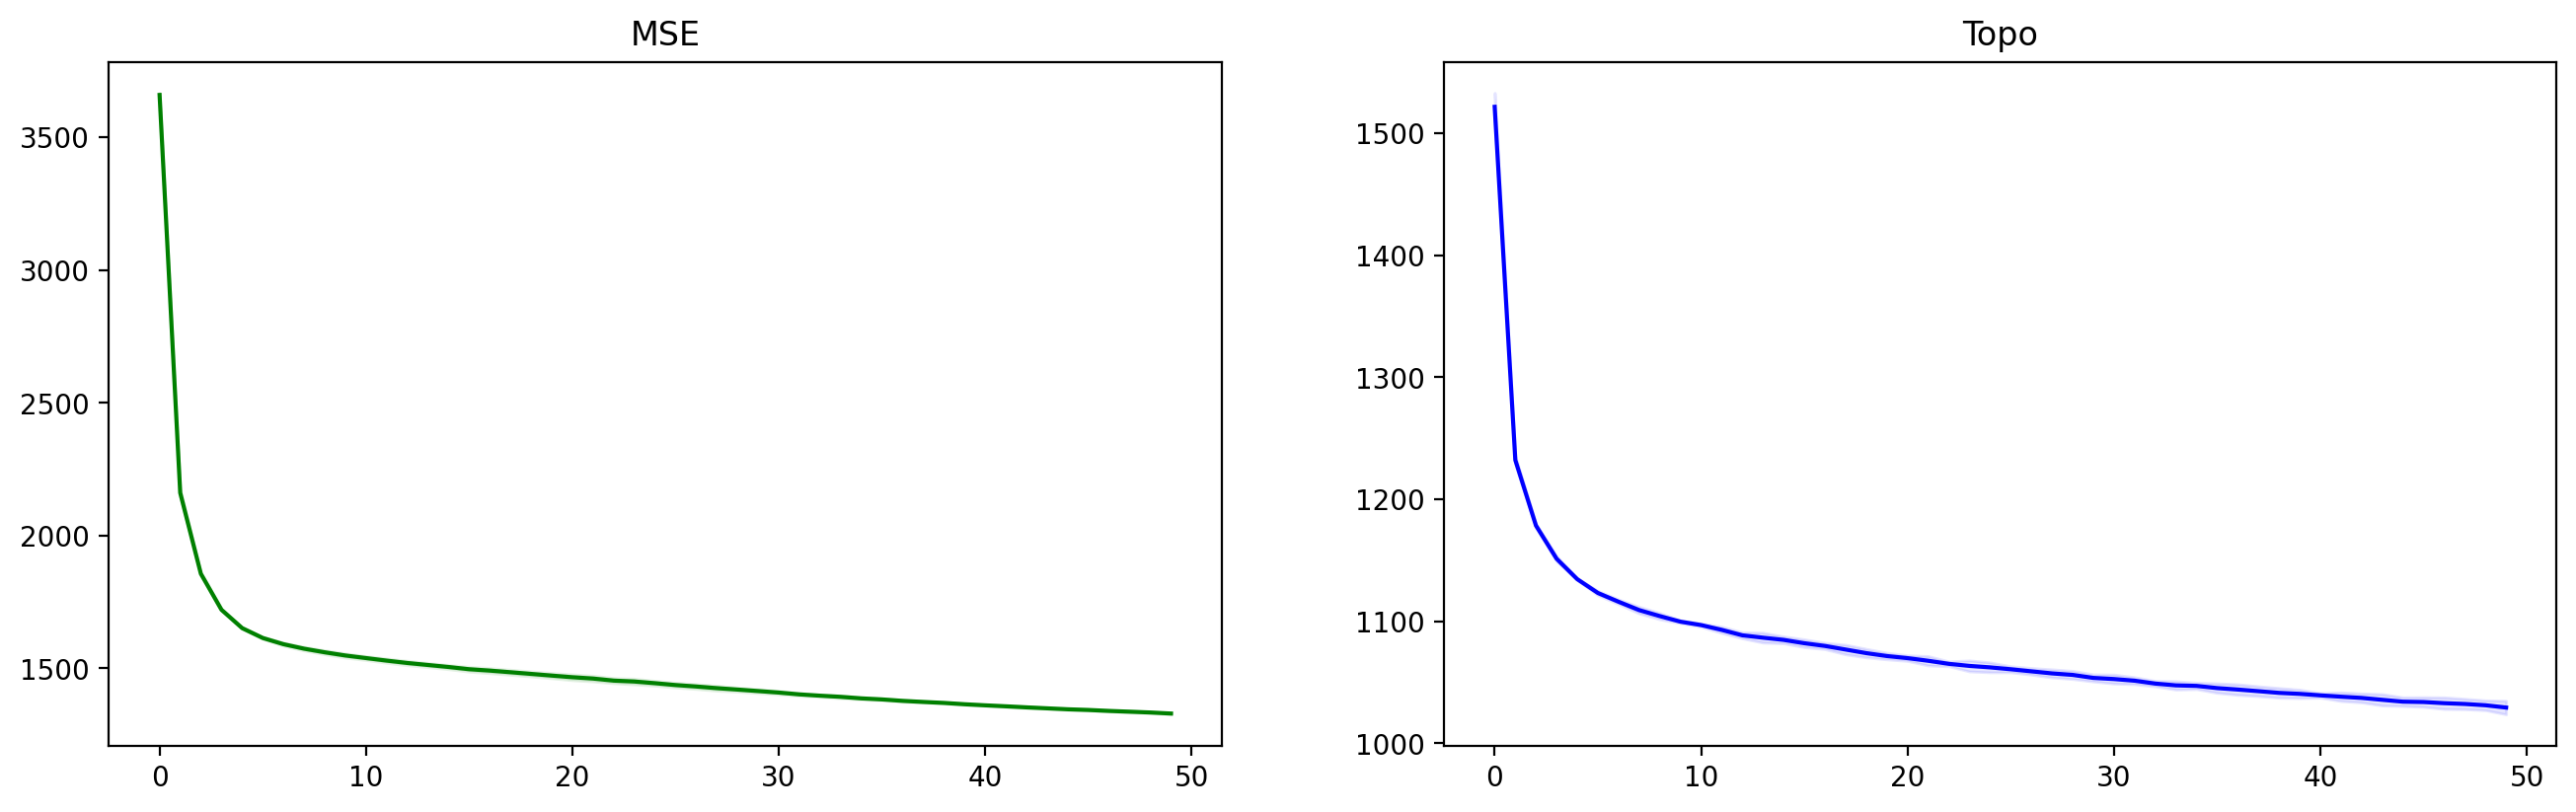

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

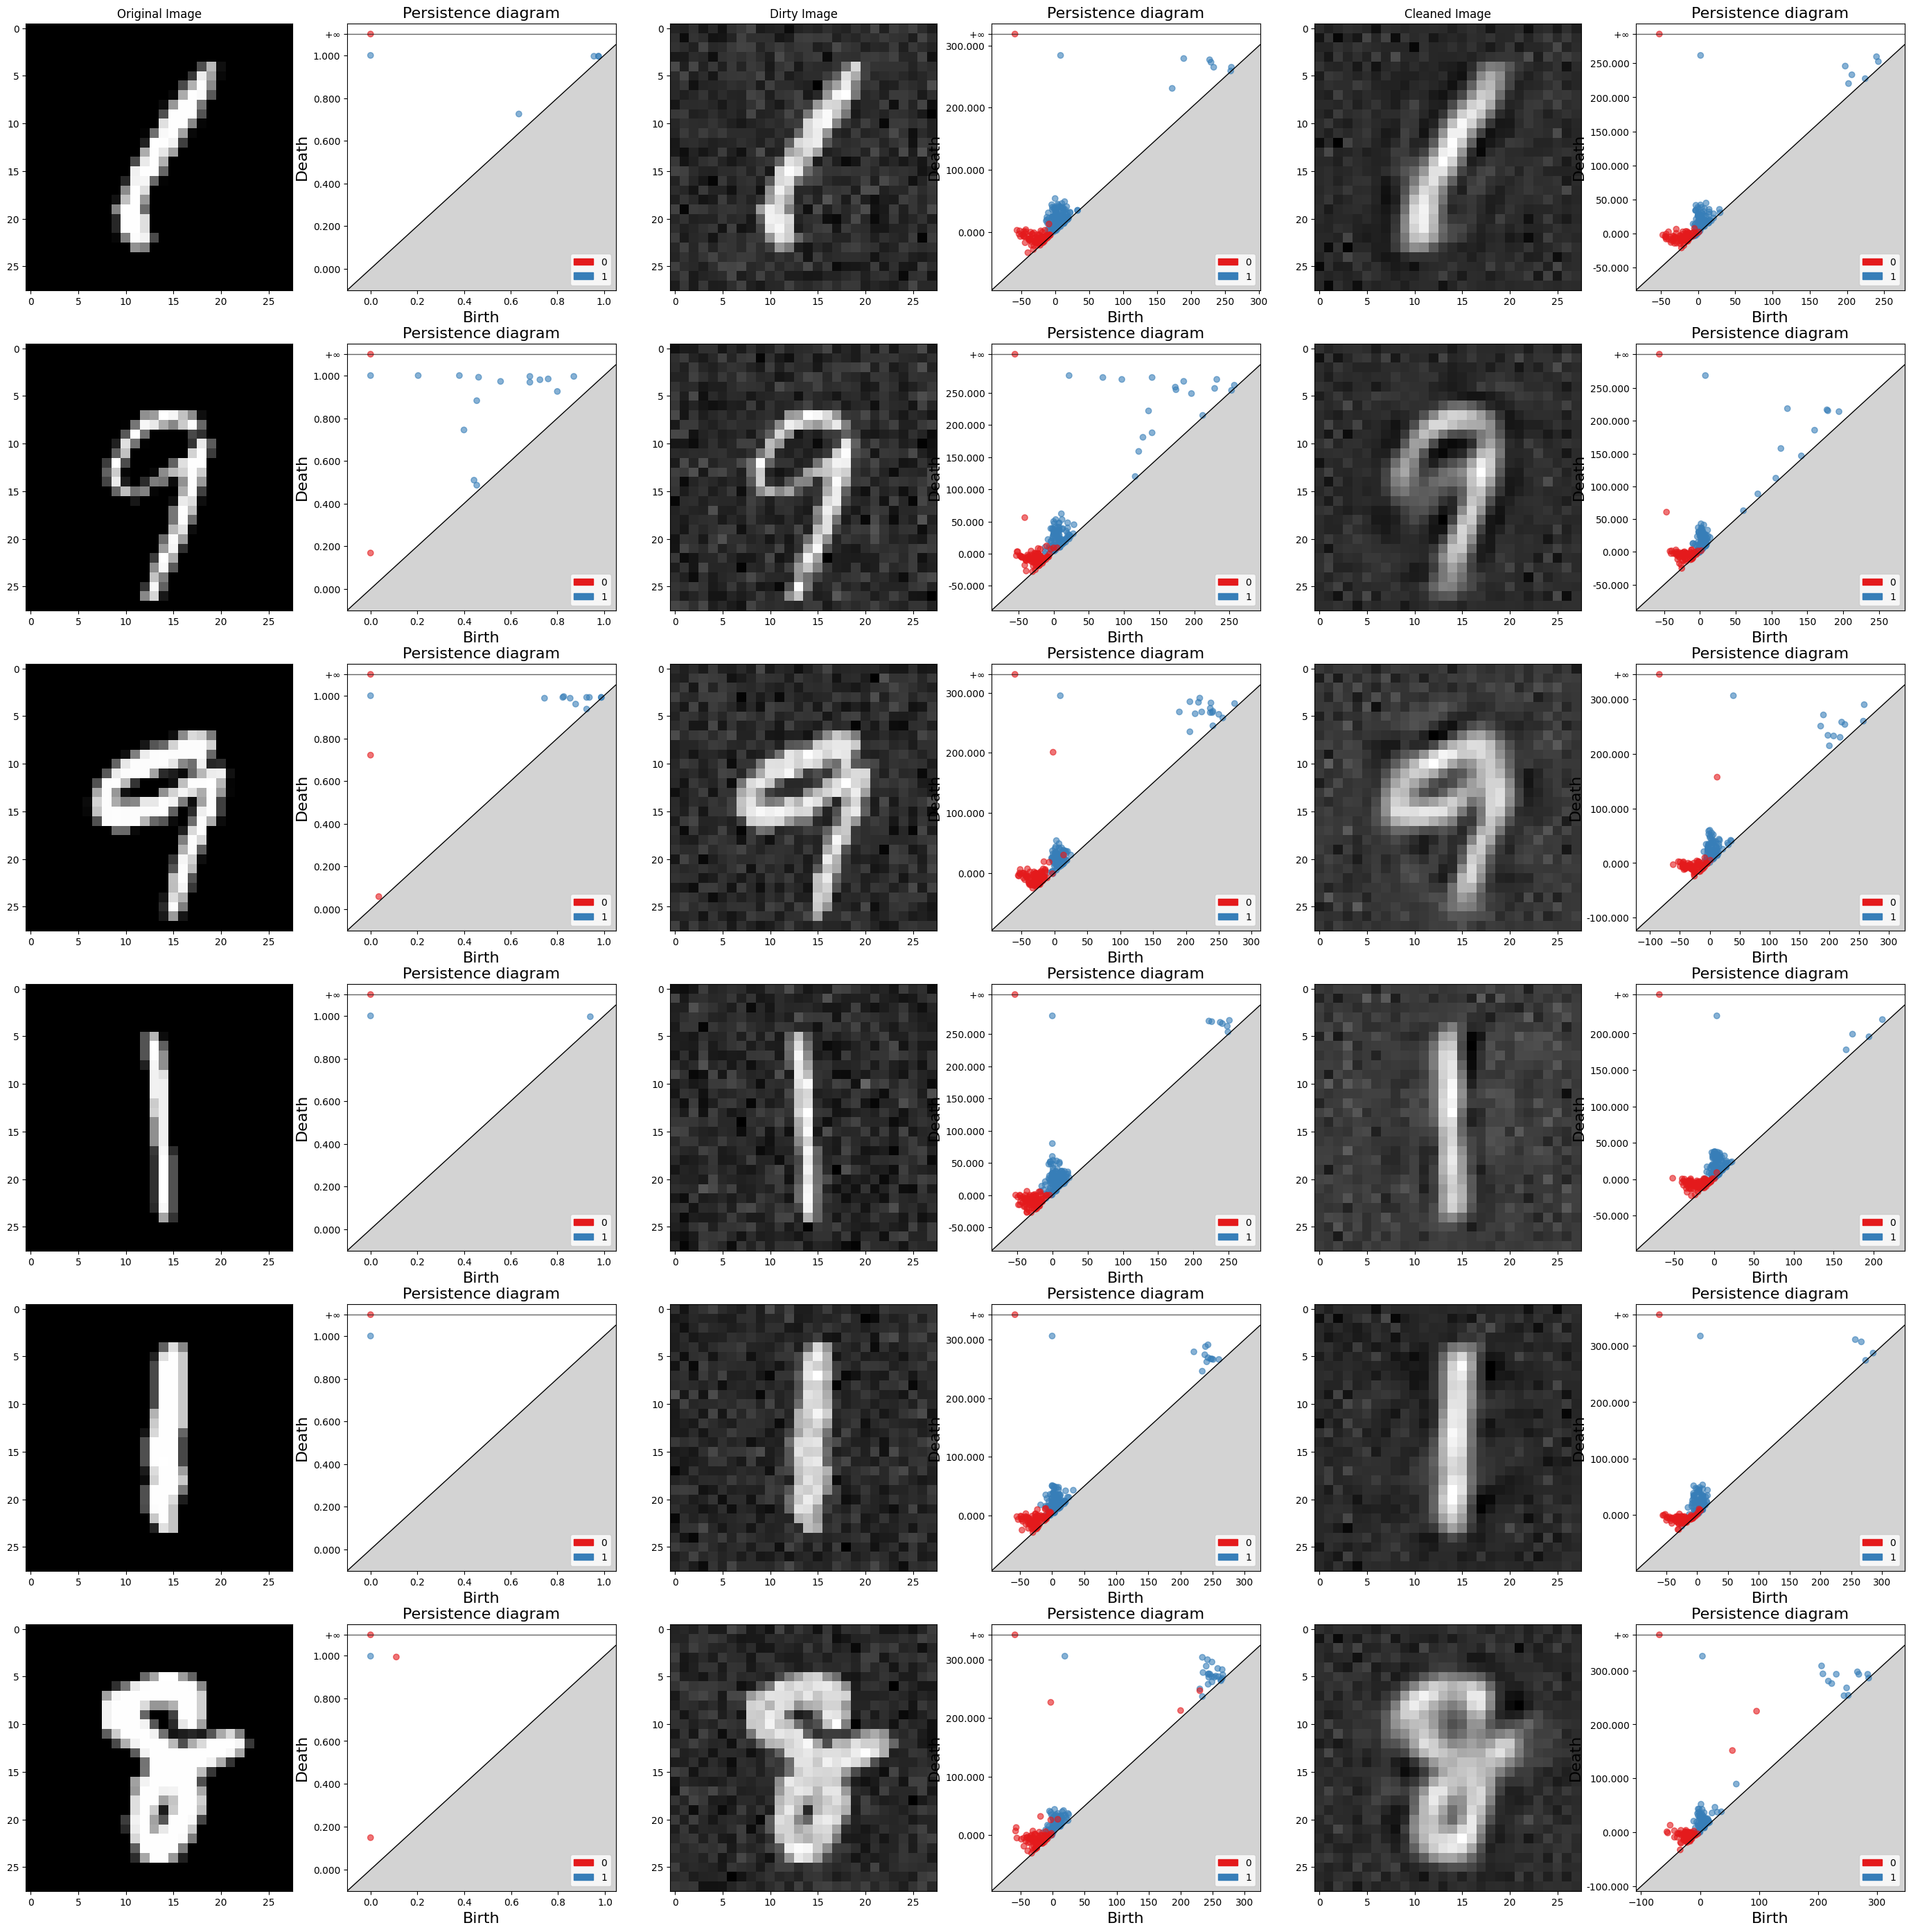

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[3649.24047852 1505.71557617]
  [2166.73217773 1236.07629395]
  [1856.54870605 1180.16809082]
  [1720.8614502  1153.35949707]
  [1653.37036133 1134.43505859]
  [1614.01501465 1124.85131836]
  [1589.91674805 1118.60192871]
  [1573.84240723 1113.05810547]
  [1562.52453613 1107.97131348]
  [1550.70080566 1100.49438477]
  [1540.98535156 1098.58337402]
  [1533.3482666  1096.54003906]
  [1525.73449707 1092.13708496]
  [1518.64685059 1091.41577148]
  [1511.88500977 1088.15124512]
  [1504.54089355 1085.39575195]
  [1501.21154785 1083.54772949]
  [1495.71264648 1080.71789551]
  [1489.14465332 1078.40588379]
  [1483.89355469 1074.88024902]
  [1478.39160156 1072.77990723]
  [1472.33483887 1072.58422852]
  [1463.80456543 1067.22912598]
  [1461.95922852 1069.69445801]
  [1452.8494873  1066.68078613]
  [1446.65856934 1063.48291016]
  [1441.14868164 1062.3873291 ]
  [1434.93518066 1061.55773926]
  [1428.07641602 1060.89453125]
  [1421.76635742 1057.60534668]
  [1414.64074707 1057.83203125]
  [1406.